#MEGALINE ANALYTICS:

##Importes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
from IPython.display import display
from google.colab import drive
import csv
from datetime import datetime
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Carga de DataFrames

In [ ]:
path = "/content/drive/My Drive/Evaluación Aleph/datos/"

megaline_users = pd.read_csv(path + "megaline_users.csv", encoding = "latin-1")
# megaline_users: user_id, first_name, last_name, age, city, reg_date, plan, churn_date
megaline_users.dropna()

megaline_plans = pd.read_csv(path + "megaline_plans.csv", encoding = "latin-1")
# megaline_plans: messages_included, mb_per_month_included, minutes_included, usd_monthly_pay, usd_per_gb, usd_per_message, usd_per_minute, plan_name

megaline_internet = pd.read_csv(path + "megaline_internet.csv", encoding = "latin-1")
# megaline_internet: id,user_id,session_date,mb_used

megaline_messages = pd.read_csv(path + "megaline_messages.csv", encoding = "latin-1")
# megaline_messages: id,user_id,message_date

megaline_calls = pd.read_csv(path + "megaline_calls.csv", encoding = "latin-1")
# megaline_calls: id,user_id,call_date,duration

def consulta(query):
  return sqldf(query, globals())

display(megaline_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


##PUNTO 1: edad promedio y diagrama
Para este ejercicio se haran todas las extracciones de datos mediante SQL. Para este punto extraemos el promedio de edad del plan surf, mientras hacemos un diagrama para todas las edades del plan ultimate

Edad promedio en el plan surf:  44.95280235988201


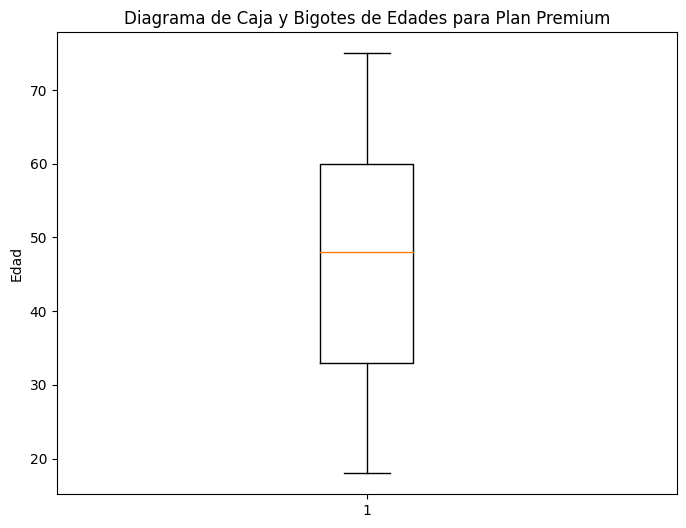

In [ ]:
promedio_edad = consulta("SELECT AVG(age) FROM megaline_users WHERE plan = 'surf'").iloc[0]['AVG(age)']

print("Edad promedio en el plan surf: ", promedio_edad)

plot_premium = consulta("SELECT age FROM megaline_users WHERE plan = 'ultimate'")

plt.figure(figsize=(8, 6))
plt.boxplot(plot_premium)

plt.title('Diagrama de Caja y Bigotes de Edades para Plan Premium')
plt.ylabel('Edad')

plt.show()

##PUNTO 2: ingreso del periodo
Aqui se extraen todos los datos necesarios para poder multiplicar el numero de usuarios por sus respectivas mensualidades, tambien tomamos en cuenta los beneficios que tienen los planes de cada uno de los clientes para que solo se tome en cuenta el cargo respectivo cuando el usuario se excede de los beneficios de su plan.


In [ ]:
usuarios_surf = consulta("SELECT COUNT() FROM megaline_users WHERE plan = 'surf'").iloc[0]['COUNT()']
gb_incluidos_surf = usuarios_surf * consulta("SELECT mb_per_month_included FROM megaline_plans WHERE plan_name = 'surf'").iloc[0]['mb_per_month_included']
msg_incluidos_surf = usuarios_surf * consulta("SELECT messages_included FROM megaline_plans WHERE plan_name = 'surf'").iloc[0]['messages_included']
minutos_incluidos_surf = consulta("SELECT minutes_included FROM megaline_plans WHERE plan_name = 'surf'").iloc[0]['minutes_included']
minutos_surf = consulta("SELECT plan, SUM(duration) AS duracion FROM megaline_users JOIN megaline_calls ON megaline_users.user_id = megaline_calls.user_id GROUP BY plan").iloc[0]['duracion']
gb_surf = consulta("SELECT plan, SUM(mb_used) AS duracion FROM megaline_users JOIN megaline_internet ON megaline_users.user_id = megaline_internet.user_id GROUP BY plan").iloc[0]['duracion']
msg_surf = consulta("SELECT plan, COUNT() AS duracion FROM megaline_users JOIN megaline_messages ON megaline_users.user_id = megaline_messages.user_id GROUP BY plan").iloc[0]['duracion']

personas_en_surf = usuarios_surf * consulta("SELECT usd_monthly_pay FROM megaline_plans WHERE plan_name = 'surf'").iloc[0]['usd_monthly_pay']
ingreso_gb_surf = (gb_surf - gb_incluidos_surf) *consulta("SELECT usd_per_gb FROM megaline_plans WHERE plan_name = 'surf'").iloc[0]['usd_per_gb']
ingreso_msg_surf = (msg_surf - msg_incluidos_surf) *consulta("SELECT usd_per_message FROM megaline_plans WHERE plan_name = 'surf'").iloc[0]['usd_per_message']
ingreso_llamadas_surf = (minutos_surf - minutos_incluidos_surf) *consulta("SELECT usd_per_minute FROM megaline_plans WHERE plan_name = 'surf'").iloc[0]['usd_per_minute']

ingreso_surf = personas_en_surf + ingreso_gb_surf  + ingreso_msg_surf + ingreso_msg_surf

usuarios_ultimate = consulta("SELECT COUNT() FROM megaline_users WHERE plan = 'ultimate'").iloc[0]['COUNT()']
gb_incluidos_ultimate = usuarios_ultimate * consulta("SELECT mb_per_month_included FROM megaline_plans WHERE plan_name = 'ultimate'").iloc[0]['mb_per_month_included']
msg_incluidos_ultimate = usuarios_ultimate * consulta("SELECT messages_included FROM megaline_plans WHERE plan_name = 'ultimate'").iloc[0]['messages_included']
minutos_incluidos_ultimate = consulta("SELECT minutes_included FROM megaline_plans WHERE plan_name = 'ultimate'").iloc[0]['minutes_included']

minutos_ultimate = consulta("SELECT plan, SUM(duration) AS duracion FROM megaline_users JOIN megaline_calls ON megaline_users.user_id = megaline_calls.user_id GROUP BY plan").iloc[1]['duracion']
gb_ultimate = consulta("SELECT plan, SUM(mb_used) AS duracion FROM megaline_users JOIN megaline_internet ON megaline_users.user_id = megaline_internet.user_id GROUP BY plan").iloc[1]['duracion']
msg_ultimate = consulta("SELECT plan, COUNT() AS duracion FROM megaline_users JOIN megaline_messages ON megaline_users.user_id = megaline_messages.user_id GROUP BY plan").iloc[1]['duracion']

personas_en_ultimate = usuarios_ultimate * consulta("SELECT usd_monthly_pay FROM megaline_plans WHERE plan_name = 'ultimate'").iloc[0]['usd_monthly_pay']
ingreso_gb_ultimate = (gb_ultimate - gb_incluidos_ultimate) *consulta("SELECT usd_per_gb FROM megaline_plans WHERE plan_name = 'ultimate'").iloc[0]['usd_per_gb']
ingreso_msg_ultimate = (msg_ultimate - msg_incluidos_ultimate) *consulta("SELECT usd_per_message FROM megaline_plans WHERE plan_name = 'ultimate'").iloc[0]['usd_per_message']
ingreso_llamadas_ultimate = (minutos_ultimate - minutos_incluidos_ultimate) *consulta("SELECT usd_per_minute FROM megaline_plans WHERE plan_name = 'ultimate'").iloc[0]['usd_per_minute']

ingreso_ultimate = personas_en_ultimate + ingreso_gb_ultimate  + ingreso_msg_ultimate + ingreso_msg_ultimate

ingreso_total = ingreso_ultimate + ingreso_surf

print("Ingreso bruto: ", ingreso_total)


PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)

##PUNTO 3: rangos de edad
Para este ejercicio se utilizaran rangos de 3 años debido a que, siendo la edad maxima 75 años y la minima 18, esta restriccion divide a estos 57 años en 19 intervalos lo suficientemente pequeños para ser analizados


In [ ]:
suma_mb_grupo = np.zeros(19)
for i in range(19):
    for j in range(3):
        edad = 18 + 3*(i) + j+1
        resultado = consulta("SELECT SUM(age) AS suma_edades FROM megaline_users JOIN megaline_internet ON megaline_internet.user_id = megaline_users.user_id WHERE age = {}".format(edad))
        suma_mb_grupo[i] += resultado.iloc[0]['suma_edades'] #demora un poco en ejecutar

maximo = np.max(suma_mb_grupo)
edadmax = np.argmax(suma_mb_grupo) * 3 + 18
print("El rango edad que mas datos consume es de ", edadmax," a ", edadmax + 3, " años con ", maximo, " mb")

##PUNTO 4: llamadas y duracion
Utilizamos los mismos rangos que arriba y ahora ajustamos la consulta para mostrar la sumatoria de tiempo de llamadas para cada grupo de edad para asi mostrar el *histograma*

In [ ]:
suma_duracion_grupo = np.zeros(19)
for i in range(19):
    for j in range(3):
        edad = 18 + 3*(i) + j+1
        resultado = consulta("SELECT SUM(duration) AS suma_edades FROM megaline_users JOIN megaline_calls ON megaline_calls.user_id = megaline_users.user_id WHERE age = {}".format(edad))
        suma_duracion_grupo[i] += resultado.iloc[0]['suma_edades'] #demora un poco en ejecutar

edades = np.arange(18, 18 + 3*19, 3)

plt.bar(edades, suma_duracion_grupo, width=2.5, color='blue')

plt.xlabel('Edad')
plt.ylabel('Suma de duración de llamadas')
plt.title('Histograma de suma de duración total de llamadas por edad')

plt.show()

##PUNTO 5: Promedio de datos utilizados
Aqui solo tomamos el numero total de datos y los dividimos entre los meses del periodo visible en los datos (de enero 1 2018 a diciembre 31 2018)

In [ ]:
promedio_mb_surf = gb_surf/12
promedio_mb_ultimate = gb_ultimate/12
print("Promedio de datos utilizados al mes por todos los usuarios del plan surf: ", promedio_mb_surf)
print("Promedio de datos utilizados al mes por todos los usuarios del plan ultimate: ", promedio_mb_ultimate)

##PUNTO 6, 6.1, 7: Resumen de usuario y conveniencia de plan
Tomando el numero de mb como criterio, se ha determinado que si el plan es surf y consumo mayor a 23000 mb o su el plan es ultimate y el consumo menor a 23000 no le conviene al cliente su eleccion. Esto debido a que, manteniendo el consumo promedio, saldría más barato cambiarse a la alternativa

In [ ]:
def resumen_usuarios():

   planes = consulta("SELECT u.user_id, p.plan_name, u.reg_date FROM megaline_users u JOIN megaline_plans p ON u.plan = p.plan_name")
   planes['reg_date'] = pd.to_datetime(planes['reg_date'])

   llamadas = consulta("SELECT user_id, COUNT(*) AS llamadas_realizadas FROM megaline_calls GROUP BY user_id")

   mb = consulta("SELECT user_id, SUM(mb_used) AS mb_utilizados FROM megaline_internet GROUP BY user_id")

   mensajes = consulta("SELECT user_id, COUNT(*) AS mensajes_enviados FROM megaline_messages GROUP BY user_id")

   planes['meses_uso'] = (datetime(2019, 1, 1) - planes['reg_date']) / pd.Timedelta(days=30)
   planes['meses_uso'] = planes['meses_uso'].apply(lambda x: int(x))

   resumen = planes.merge(llamadas, how='outer', on='user_id') \
                   .merge(mb, how='outer', on='user_id') \
                   .merge(mensajes, how='outer', on='user_id') \
                   .fillna(0)
   return resumen
resumen = resumen_usuarios()

# Determinando si conviene o no basandonos en el los mb usados por mes de cada usuario
# no conviene si el plan es surf y consumo mayor a 23000 mb o su el plan es ultimate y el consumo menor a 23000
# print(resumen)

for i in range(5):
  id = 1001 + i
  meses_uso = consulta("SELECT meses_uso FROM resumen WHERE user_id = {}".format(id)).iloc[0]['meses_uso']
  mb_uso = consulta("SELECT mb_utilizados FROM resumen WHERE user_id = {}".format(id)).iloc[0]['mb_utilizados']
  plan = consulta("SELECT plan_name FROM resumen WHERE user_id = {}".format(id)).iloc[0]['plan_name']
  if(mb_uso/meses_uso > 23000 and plan == "surf" or mb_uso < 23000 and plan == "ultimate"):
    print("Al usuario ", id, " no le conviene su plan")
  else:
    print("Al usuario ", id, " le conviene su plan")

##PUNTO 8: Analisis de estatus socioeconomico
Contaremos la zona con mas usuarios ultimate como la de mejor nivel socioeconomico, ya que la muestra es representativa.

In [ ]:
ciudad_ultimate = consulta("SELECT city FROM megaline_users WHERE plan = 'ultimate' GROUP BY city ORDER BY COUNT(*) DESC LIMIT 1").iloc[0]['city']
print("Según nuestros criterios, la ciudad de mayor nivel socioeconomico es: ", ciudad_ultimate)